# Modeling Pat Adoption with RandomForestClassifier

This notebook will use the Random Trees Algorithm for prediction of pet's adoption speed
- Metrics: Accuracy and Cohen's Weighted Kappa 
- Comparing model performance for cats and dogs combined vs. seperately. We will evaluate the overall accuracy for cats and dogs with 
  acc_combined_model = ((acc_cats * number_cats) + (acc_dogs * number_dogs))/(number_cats + number_dogs)

In [2]:
# importing necessary libraries and dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix

# import custom functions
from custom_functions import our_metrics, get_kappa, model_hyperparams, combined_metrics

# display options
pd.set_option('display.max_rows', None)





# Import processed data - Cats and Dogs Combined

In [3]:
# import features
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

# turn target df into 1D-array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()                  

# 

# Random Forest Default Model - Entire Data Set

In [4]:
# instantiate and fit the default RFC on all features
rf_def = RandomForestClassifier()
rf_def.fit(X_train, y_train)

# predict train-target
rf_def_y_train_pred = rf_def.predict(X_train)
# predict test-target
rf_def_y_test_pred = rf_def.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_def)

__________________________________
Average number of nodes in the forest: 8133
__________________________________
Average depth trees in the forest: 28
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.9904
_____________________
Weighted Quadratic Kappa: 0.9918


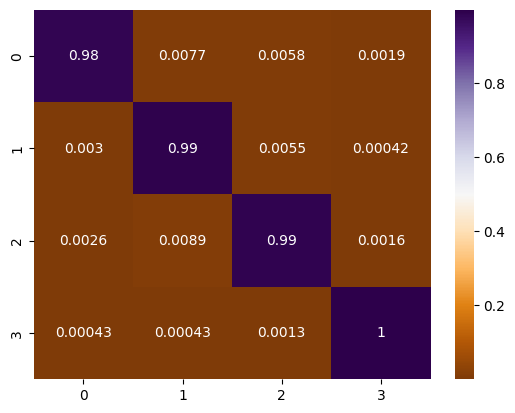

In [5]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_def_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.3748
_____________________
Weighted Quadratic Kappa: 0.2584


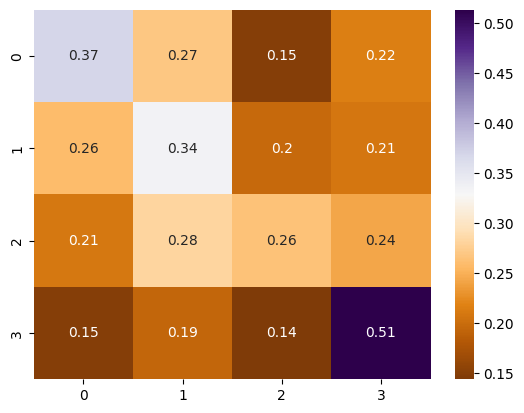

In [6]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_def_y_test_pred)

In [7]:
X_test.columns

Index(['type', 'gender', 'sterilized', 'breed_type', 'vaccinated_dewormed',
       'fee_bin', 'maturitysize_0', 'maturitysize_1', 'maturitysize_2',
       'maturitysize_3', 'furlength_0', 'furlength_1', 'furlength_2',
       'health_0', 'health_1', 'health_2', 'color_pattern_0',
       'color_pattern_1', 'color_pattern_2', 'photoamt_11', 'age_bin',
       'description_char'],
      dtype='object')

# Random Forest Random Grid Search Accuracy - Entire Data Set

In [8]:
# Hyperparameter grid based on hyperparameters of the default model for best accuracy:

# setting hyperparameter grid:
param_grid = {
    'n_estimators': [500],
    'max_depth': [None] + list(np.arange(10, 28)),
    'max_features': [None] + list(np.arange(1,5)),
    'min_samples_split': np.linspace(20, 200, 10).astype(int),
    'min_samples_leaf': np.linspace(10, 100, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model for best accuracy_score and 250 fits:
rf_rgs_acc = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 50, verbose = 1, random_state=42)

# Fit best model estimated by random search to train data:
rf_rgs_acc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27],
                                        'max_features': [None, 1, 2, 3, 4],
                                        'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_split': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200]),
                                        'n_estimators': [500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [9]:
# check hyperparameters of best estimator 
rf_rgs_acc.best_params_

{'n_estimators': 500,
 'min_samples_split': 60,
 'min_samples_leaf': 20,
 'max_features': 4,
 'max_depth': 25,
 'bootstrap': False}

In [10]:
# instantiate model with best estimators as found by random grid search accuracy
rf_rgs_acc_model = rf_rgs_acc.best_estimator_

# predict train-target
rf_rgs_y_train_pred = rf_rgs_acc_model.predict(X_train)
# predict test-target
rf_rgs_y_test_pred = rf_rgs_acc_model.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_rgs_acc_model.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_rgs_acc_model)

__________________________________
Average number of nodes in the forest: 357
__________________________________
Average depth trees in the forest: 14
 
 


,set hyperparams
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,25
max_features,4
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,20


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4869
_____________________
Weighted Quadratic Kappa: 0.4018


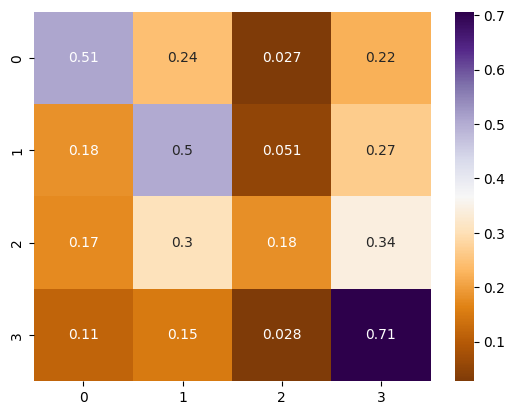

In [11]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_rgs_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4118
_____________________
Weighted Quadratic Kappa: 0.3378


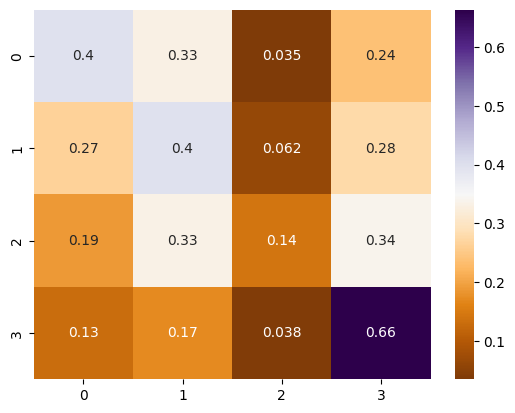

In [12]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_rgs_y_test_pred)

# Random Forest Grid Search Kappa - Entire Data Set

In [13]:
# # Hyperparameter grid based on hyperparameters of the default model for best kappa:

# # defining kappa
# kappa = get_kappa()

# # setting hyperparameter grid:
# param_grid = {
#     'n_estimators': [500],
#     'max_depth': [None] + list(np.arange(10, 28)),
#     'max_features': [None] + list(np.arange(1,5)),
#     'min_samples_split': np.linspace(20, 200, 10).astype(int),
#     'min_samples_leaf': np.linspace(10, 100, 10).astype(int),
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = RandomForestClassifier(random_state = 42)

# # Create the random search model for best accuracy_score and 250 fits:
# rf_rgs_kappa = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = kappa, cv = 5, 
#                         n_iter = 50, verbose = 1, random_state=42)

# # Fit best model estimated by random search to train data:
# rf_rgs_kappa.fit(X_train, y_train)

In [14]:
# # check hyperparameters of best estimator:
# rf_rgs_kappa.best_params_

In [15]:
# # instantiate model with best estimators as found by random grid search accuracy
# rf_rgs_kappa_model = rf_rgs_kappa.best_estimator_

# # predict train-target
# rf_rgs_y_train_pred = rf_rgs_kappa_model.predict(X_train)
# # predict test-target
# rf_rgs_y_test_pred = rf_rgs_kappa_model.predict(X_test)

# # Average number of nodes and depths of trees in the forest
# n_nodes = []
# depths = []

# for single_tree in rf_rgs_kappa_model.estimators_:
#     n_nodes.append(single_tree.tree_.node_count)
#     depths.append(single_tree.tree_.max_depth)

# print('__________________________________')
# print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
# print('__________________________________')
# print(f'Average depth trees in the forest: {int(np.mean(depths))}')
# print(' ')
# print(' ')

# model_hyperparams(rf_rgs_kappa_model)

In [16]:
# # Metrics predicting Test-Target
# print('*** Model Evaluation: Predicting Test-Labels ***')
# our_metrics(y_test, rf_rgs_y_test_pred)

# Random Forest Grid Search Accuracy: Entire Data Set

In [17]:
# Hyperparameter grid based on hyperparameters of the default model for best accuracy:

# setting hyperparameter grid:
param_grid = {
    'n_estimators': [500],
    'max_depth': [20, 21, 22],
    'max_features': [4],
    'min_samples_split': [49,50,51],
    'min_samples_leaf': [14, 15, 16],
    'bootstrap': [False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model for best accuracy_score and 250 fits:
rf_gs_acc = GridSearchCV(estimator, param_grid, n_jobs = -1, scoring = 'accuracy', cv = 5, verbose = 1)

# Fit best model estimated by random search to train data:
rf_gs_acc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [20, 21, 22],
                         'max_features': [4], 'min_samples_leaf': [14, 15, 16],
                         'min_samples_split': [49, 50, 51],
                         'n_estimators': [500]},
             scoring='accuracy', verbose=1)

In [18]:
# check hyperparameters of best estimator:
rf_gs_acc.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 4,
 'min_samples_leaf': 15,
 'min_samples_split': 50,
 'n_estimators': 500}

In [19]:
# instantiate model with best estimators as found by grid search accuracy
rf_gs_acc_model = rf_gs_acc.best_estimator_

# predict train-target
rf_gs_y_train_pred = rf_gs_acc_model.predict(X_train)
# predict test-target
rf_gs_y_test_pred = rf_gs_acc_model.predict(X_test)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_gs_acc_model.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_gs_acc_model)

__________________________________
Average number of nodes in the forest: 440
__________________________________
Average depth trees in the forest: 15
 
 


,set hyperparams
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,20
max_features,4
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,15


*** Model Evaluation: Predicting Train-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.5071
_____________________
Weighted Quadratic Kappa: 0.4211


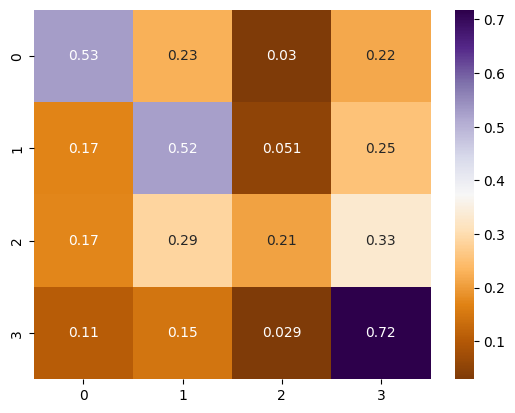

In [20]:
# Metrics predicting Train-Target
print('*** Model Evaluation: Predicting Train-Labels ***')
our_metrics(y_train, rf_gs_y_train_pred)

*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4149
_____________________
Weighted Quadratic Kappa: 0.3413


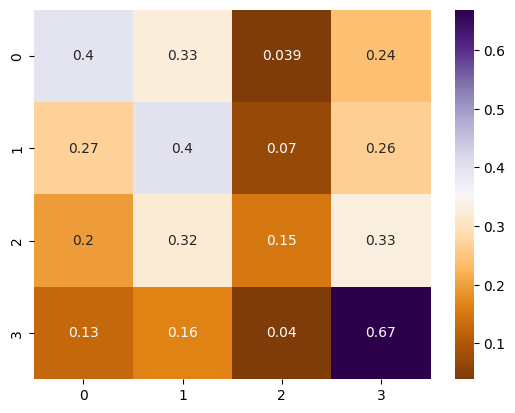

In [21]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test, rf_gs_y_test_pred)

# Combine Target Categories 2+3

In [22]:
# combine Target 2 and 3 (3 categories)
y_train_3 = [2 if x == 3 else x for x in y_train]
y_test_3 = [2 if x == 3 else x for x in y_test]

In [23]:
# check if that worked
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

[1 2 3 4] [2077 2372 1914 2310]


In [24]:
# # fit model as found in grid search to new target
# rf_gs_model_3 = rf_gs_acc.best_estimator_
# rf_gs_model_3.fit(X_train, y_train_3)

In [25]:
# # predict train-target
# rf_gs_y_train_3_pred = rf_gs_model_3.predict(X_train)

# # Metrics predicting Train-Target
# print('*** Model Evaluation: Predicting Train-Labels ***')
# our_metrics(y_train_3, rf_gs_y_train_3_pred)


In [26]:
# # predict Test-Target
# rf_gs_y_test_3_pred = rf_gs_model_3.predict(X_test)

# # Metrics predicting Test-Target
# print('*** Model Evaluation: Predicting Test-Labels ***')
# our_metrics(y_test_3, rf_gs_y_test_3_pred)

# Random Forest Default Model - Dogs

In [27]:
# read in dogs features and target (4 categories)
X_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_all.csv')
y_train_dogs_4 = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv')

X_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_all.csv')
y_test_dogs_4 = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv')

In [28]:
X_test_dogs.columns

Index(['gender', 'sterilized', 'breed_type', 'vaccinated_dewormed', 'fee_bin',
       'maturitysize_0', 'maturitysize_1', 'maturitysize_2', 'maturitysize_3',
       'furlength_0', 'furlength_1', 'furlength_2', 'health_0', 'health_1',
       'health_2', 'color_pattern_0', 'color_pattern_1', 'color_pattern_2',
       'photoamt_11', 'age_bin', 'description_char'],
      dtype='object')

In [29]:
# instantiate and fit the default RFC on dogs
rf_def_dogs = RandomForestClassifier()
rf_def_dogs.fit(X_train_dogs, y_train_dogs_4)

# predict train-target
rf_def_dogs_y_train_pred = rf_def_dogs.predict(X_train_dogs)
# predict test-target
rf_def_dogs_y_test_pred = rf_def_dogs.predict(X_test_dogs)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def_dogs.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_def_dogs)

/var/folders/0r/8xzhnvk55wbfn1wf1m61sm5h0000gn/T/ipykernel_8278/2606056791.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_def_dogs.fit(X_train_dogs, y_train_dogs_4)


__________________________________
Average number of nodes in the forest: 4526
__________________________________
Average depth trees in the forest: 26
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.3744
_____________________
Weighted Quadratic Kappa: 0.2862


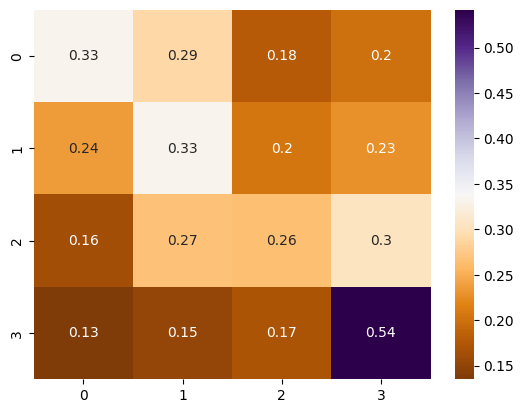

In [30]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test_dogs_4, rf_def_dogs_y_test_pred)

In [31]:
# Hyperparameter grid based on hyperparameters of the default model for dogs best accuracy:

# setting hyperparameter grid:
param_grid = {
    'n_estimators': [500],
    'max_depth': [None] + list(np.arange(10, 28)),
    'max_features': [None] + list(np.arange(1,5)),
    'min_samples_split': np.linspace(20, 200, 10).astype(int),
    'min_samples_leaf': np.linspace(10, 100, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model for best accuracy_score and 250 fits:
rf_rgs_acc_dogs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 50, verbose = 1, random_state=42)

# Fit best model estimated by random search to train data:
rf_rgs_acc_dogs.fit(X_train_dogs, y_train_dogs_4)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_trai

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27],
                                        'max_features': [None, 1, 2, 3, 4],
                                        'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_split': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200]),
                                        'n_estimators': [500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [32]:
# instantiate model with best estimators as found by grid search accuracy
rf_rgs_acc_dogs_model = rf_rgs_acc_dogs.best_estimator_

# predict train-target
rf_rgs_y_train_pred_dogs = rf_rgs_acc_dogs_model.predict(X_train_dogs)
# predict test-target
rf_rgs_y_test_pred_dogs = rf_rgs_acc_dogs_model.predict(X_test_dogs)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_rgs_acc_dogs_model.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_rgs_acc_dogs_model)

__________________________________
Average number of nodes in the forest: 194
__________________________________
Average depth trees in the forest: 13
 
 


,set hyperparams
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,25
max_features,4
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,20


*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4106
_____________________
Weighted Quadratic Kappa: 0.3304


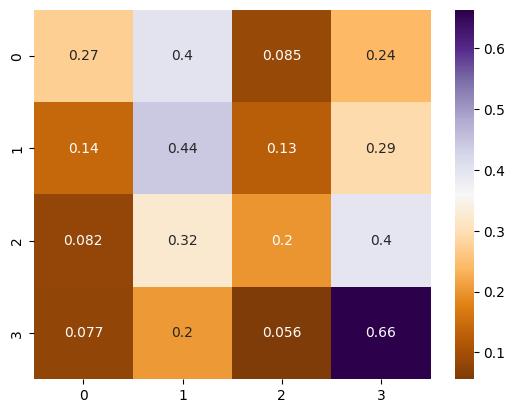

In [33]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test_dogs_4, rf_rgs_y_test_pred_dogs)

# Random Forest Default Model - Cats

In [34]:
# read in dogs features and target (4 categories)
X_train_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_cats_all.csv')
y_train_cats_4 = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_cats.csv')

X_test_cats = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_cats_all.csv')
y_test_cats_4 = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_cats.csv')

In [35]:
# instantiate and fit the default RFC on cats
rf_def_cats = RandomForestClassifier()
rf_def_cats.fit(X_train_cats, y_train_cats_4)

# predict train-target
rf_def_cats_y_train_pred = rf_def_cats.predict(X_train_cats)
# predict test-target
rf_def_cats_y_test_pred = rf_def_cats.predict(X_test_cats)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_def_cats.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_def_cats)

/var/folders/0r/8xzhnvk55wbfn1wf1m61sm5h0000gn/T/ipykernel_8278/1526174746.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_def_cats.fit(X_train_cats, y_train_cats_4)


__________________________________
Average number of nodes in the forest: 3539
__________________________________
Average depth trees in the forest: 25
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.3487
_____________________
Weighted Quadratic Kappa: 0.1836


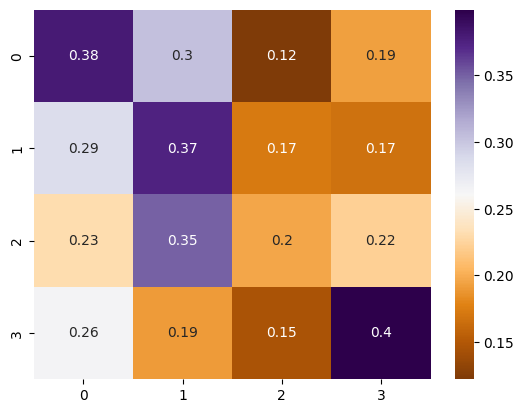

In [36]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test_cats_4, rf_def_cats_y_test_pred)

In [37]:
# Hyperparameter grid based on hyperparameters of the default model for cats best accuracy:

# setting hyperparameter grid:
param_grid = {
    'n_estimators': [500],
    'max_depth': [None] + list(np.arange(10, 28)),
    'max_features': [None] + list(np.arange(1,5)),
    'min_samples_split': np.linspace(20, 200, 10).astype(int),
    'min_samples_leaf': np.linspace(10, 100, 10).astype(int),
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)

# Create the random search model for best accuracy_score and 250 fits:
rf_rgs_acc_cats = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 50, verbose = 1, random_state=42)

# Fit best model estimated by random search to train data:
rf_rgs_acc_cats.fit(X_train_cats, y_train_cats_4)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annastein/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_trai

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27],
                                        'max_features': [None, 1, 2, 3, 4],
                                        'min_samples_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_split': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200]),
                                        'n_estimators': [500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [38]:
# instantiate model with best estimators as found by grid search accuracy
rf_rgs_acc_cats_model = rf_rgs_acc_cats.best_estimator_

# predict train-target
rf_rgs_y_train_pred_cats = rf_rgs_acc_cats_model.predict(X_train_cats)
# predict test-target
rf_rgs_y_test_pred_cats = rf_rgs_acc_cats_model.predict(X_test_cats)

# Average number of nodes and depths of trees in the forest
n_nodes = []
depths = []

for single_tree in rf_rgs_acc_cats_model.estimators_:
    n_nodes.append(single_tree.tree_.node_count)
    depths.append(single_tree.tree_.max_depth)

print('__________________________________')
print(f'Average number of nodes in the forest: {int(np.mean(n_nodes))}')
print('__________________________________')
print(f'Average depth trees in the forest: {int(np.mean(depths))}')
print(' ')
print(' ')

model_hyperparams(rf_rgs_acc_cats_model)

__________________________________
Average number of nodes in the forest: 108
__________________________________
Average depth trees in the forest: 11
 
 


,set hyperparams
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,19
max_features,3
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,20


*** Model Evaluation: Predicting Test-Labels ***
Model Metrics and Normalized Confusion Matrix:
_____________________
Accuracy: 0.4175
_____________________
Weighted Quadratic Kappa: 0.3199


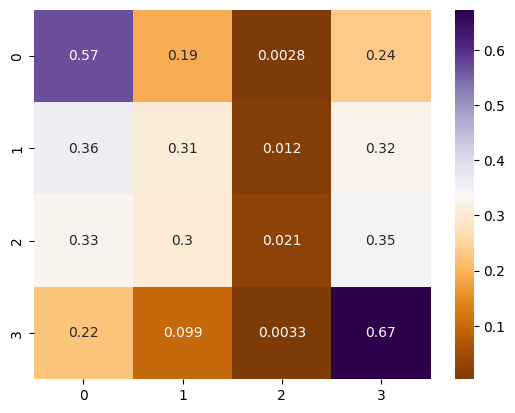

In [39]:
# Metrics predicting Test-Target
print('*** Model Evaluation: Predicting Test-Labels ***')
our_metrics(y_test_cats_4, rf_rgs_y_test_pred_cats)

In [40]:
len(rf_rgs_y_test_pred_cats)

1236

# Feature Importance

In [41]:
# features = X_train.columns.tolist()

# # data frame with feature names and feature importance scores, sorted by importance
# feature_importance = pd.DataFrame({'feature': features,
#                    'importance': best_rs_model.feature_importances_}).\
#                     sort_values('importance', ascending = False)
# # show 10 most important features
# feature_importance.head(10)

# Kappa Combined
acc_combined_model = ((acc_cats * number_cats) + (acc_dogs * number_dogs))/(number_cats + number_dogs)


In [42]:
combined_metrics(y_test_dogs_4, rf_rgs_y_test_pred_dogs, y_test_cats_4, rf_rgs_y_test_pred_cats)

**********************************************************************
Weighted Quadratic Kappa for Cats:                0.3199 
(Accuracy for Cats: 0.4175)
**********************************************************************
Weighted Quadratic Kappa for Dogs:                0.3304 
(Accuracy for Dogs: 0.4106)
**********************************************************************
**********************************************************************
Combined Kappa: 0.3258925860765528
(Combined Accuracy: 0.4135546334716459)
